| **Chapter**                   | 9:  Agent-based modeling                       |
| ----------------------------- |------------------------------------------------|
| **Computational Note**        | 9.x: Homesick random-destination walks         |
| **Package prerequisites**     | [Mesa](https://mesa.readthedocs.io/en/latest/) |


# Homesick random-destination walks

In [2]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import batchrunner
import matplotlib
from matplotlib import pyplot as plt
import osmnx
import networkx as nx
import random
from scipy import stats
import enum

SMALL_SIZE = 5
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

random.seed(1234)

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [3]:
road_filter = "['highway'~'motorway|motorway_link|trunk|primary|secondary|tertiary|residential']"

In [4]:
graph = osmnx.graph_from_place("Budapest, Hungary", network_type="drive", custom_filter=road_filter)

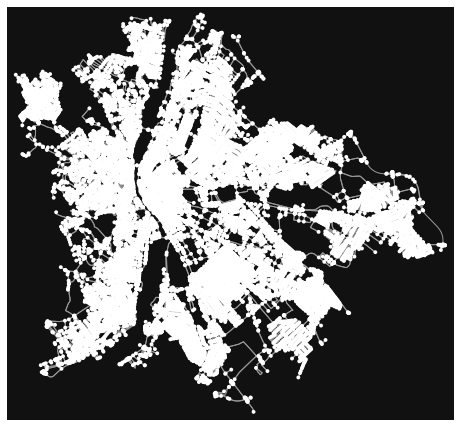

In [5]:
osmnx.plot_graph(graph)

In [6]:
class Person(Agent):
    def __init__(self, uid, model, homebase, homesickness_threshold):
        super().__init__(uid, model)
        
        self.distance_traveled = 0
        self.homebase = homebase
        self.homesickness_threshold = homesickness_threshold
        self.destination_node = None
        self.route = None

    def plot_route(self, destination):
        print(f"Plotting course from {self.pos} to {destination}.")
        route = self.model.determine_shortest_path(self.pos, destination)
        self.route = route
        route.pop(0)
        print(f"Route plotted to {destination}.")

    def move(self):
        next_node = self.route.pop(0)
        print(f"Moving to destination {next_node}.")
        self.distance_traveled += self.model.determine_distance(self.pos, next_node)
        self.pos = next_node

    def step(self):
        if self.pos == self.homebase and (self.route == None or self.destination_node == self.homebase):
            print("Agent is at home, reset distance and plot new course.")
            self.distance_traveled = 0
            self.destination_node = random.choice(list(self.model.graph.nodes.keys()))
            self.plot_route(self.destination_node)
        elif self.pos == self.destination_node:
            print("Agent is at destination.")
            self.destination_node = random.choice(list(self.model.graph.nodes.keys()))
            self.plot_route(self.destination_node)
        elif self.distance_traveled > self.homesickness_threshold and self.destination_node is not self.homebase:
            print("Agent is homesick.")
            self.plot_route(self.homebase)
            self.destination_node = self.homebase
            self.model.homesick_points.append(self.pos)
        else:
            self.move()

In [7]:
class HomesickWalkModel(Model):

    def __init__(self, homesickness_threshold=25000):
        self.graph = graph
        self.grid = NetworkGrid(self.graph)
        self.edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)

        self.schedule = RandomActivation(self)
        self.running = True

        self.homesick_points = []

        # Placing the single agent
        starting_location = random.choice(list(self.graph.nodes.keys()))
        agent = Person(uid=1234, model=self, homebase=starting_location, homesickness_threshold=homesickness_threshold)
        self.grid.place_agent(agent, starting_location)
        self.schedule.add(agent)

        self.datacollector = DataCollector(agent_reporters={"pos": "pos"})

    def determine_distance(self, node1, node2, *args) -> float:
        return self.edges.loc[(node1, node2), "length"][0]
    
    def determine_shortest_path(self, node1, node2) -> list:
        return nx.shortest_path(self.graph, node1, node2, weight=self.determine_distance, method="dijkstra")

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [8]:
nodes, edges = osmnx.graph_to_gdfs(graph)

In [9]:
model = HomesickWalkModel()

for i in range(1000):
    print(f"Time: {i}")
    print(model.schedule.agents[0].pos)
    model.step()

Time: 0
979007805
Agent is at home, reset distance and plot new course.
Plotting course from 979007805 to 260184944.
Route plotted to 260184944.
Time: 1
979007805
Moving to destination 979008203.
Time: 2
979008203
Moving to destination 146894824.
Time: 3
146894824
Moving to destination 235882233.
Time: 4
235882233
Moving to destination 235881405.
Time: 5
235881405
Moving to destination 1314960250.
Time: 6
1314960250
Moving to destination 235875937.
Time: 7
235875937
Moving to destination 235874911.
Time: 8
235874911
Moving to destination 235833128.
Time: 9
235833128
Moving to destination 235831370.
Time: 10
235831370
Moving to destination 235838129.
Time: 11
235838129
Moving to destination 235897822.
Time: 12
235897822
Moving to destination 494320476.
Time: 13
494320476
Moving to destination 235811306.
Time: 14
235811306
Moving to destination 221623014.
Time: 15
221623014
Moving to destination 235798767.
Time: 16
235798767
Moving to destination 130617334.
Time: 17
130617334
Moving to d

<ipython-input-7-eba1c9f77369>:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self.edges.loc[(node1, node2), "length"][0]


In [10]:
agent_vars = model.datacollector.get_agent_vars_dataframe()

In [11]:
pos_list = agent_vars.reset_index()[["Step", "pos"]]

In [12]:
pos_list["v"] = pos_list.pos.shift(-1)
pos_list = pos_list.rename(columns={"pos": "u"})

In [13]:
edges_ri = edges.reset_index()

In [14]:
model.homesick_points

[1253800341, 1261091812, 263368019]

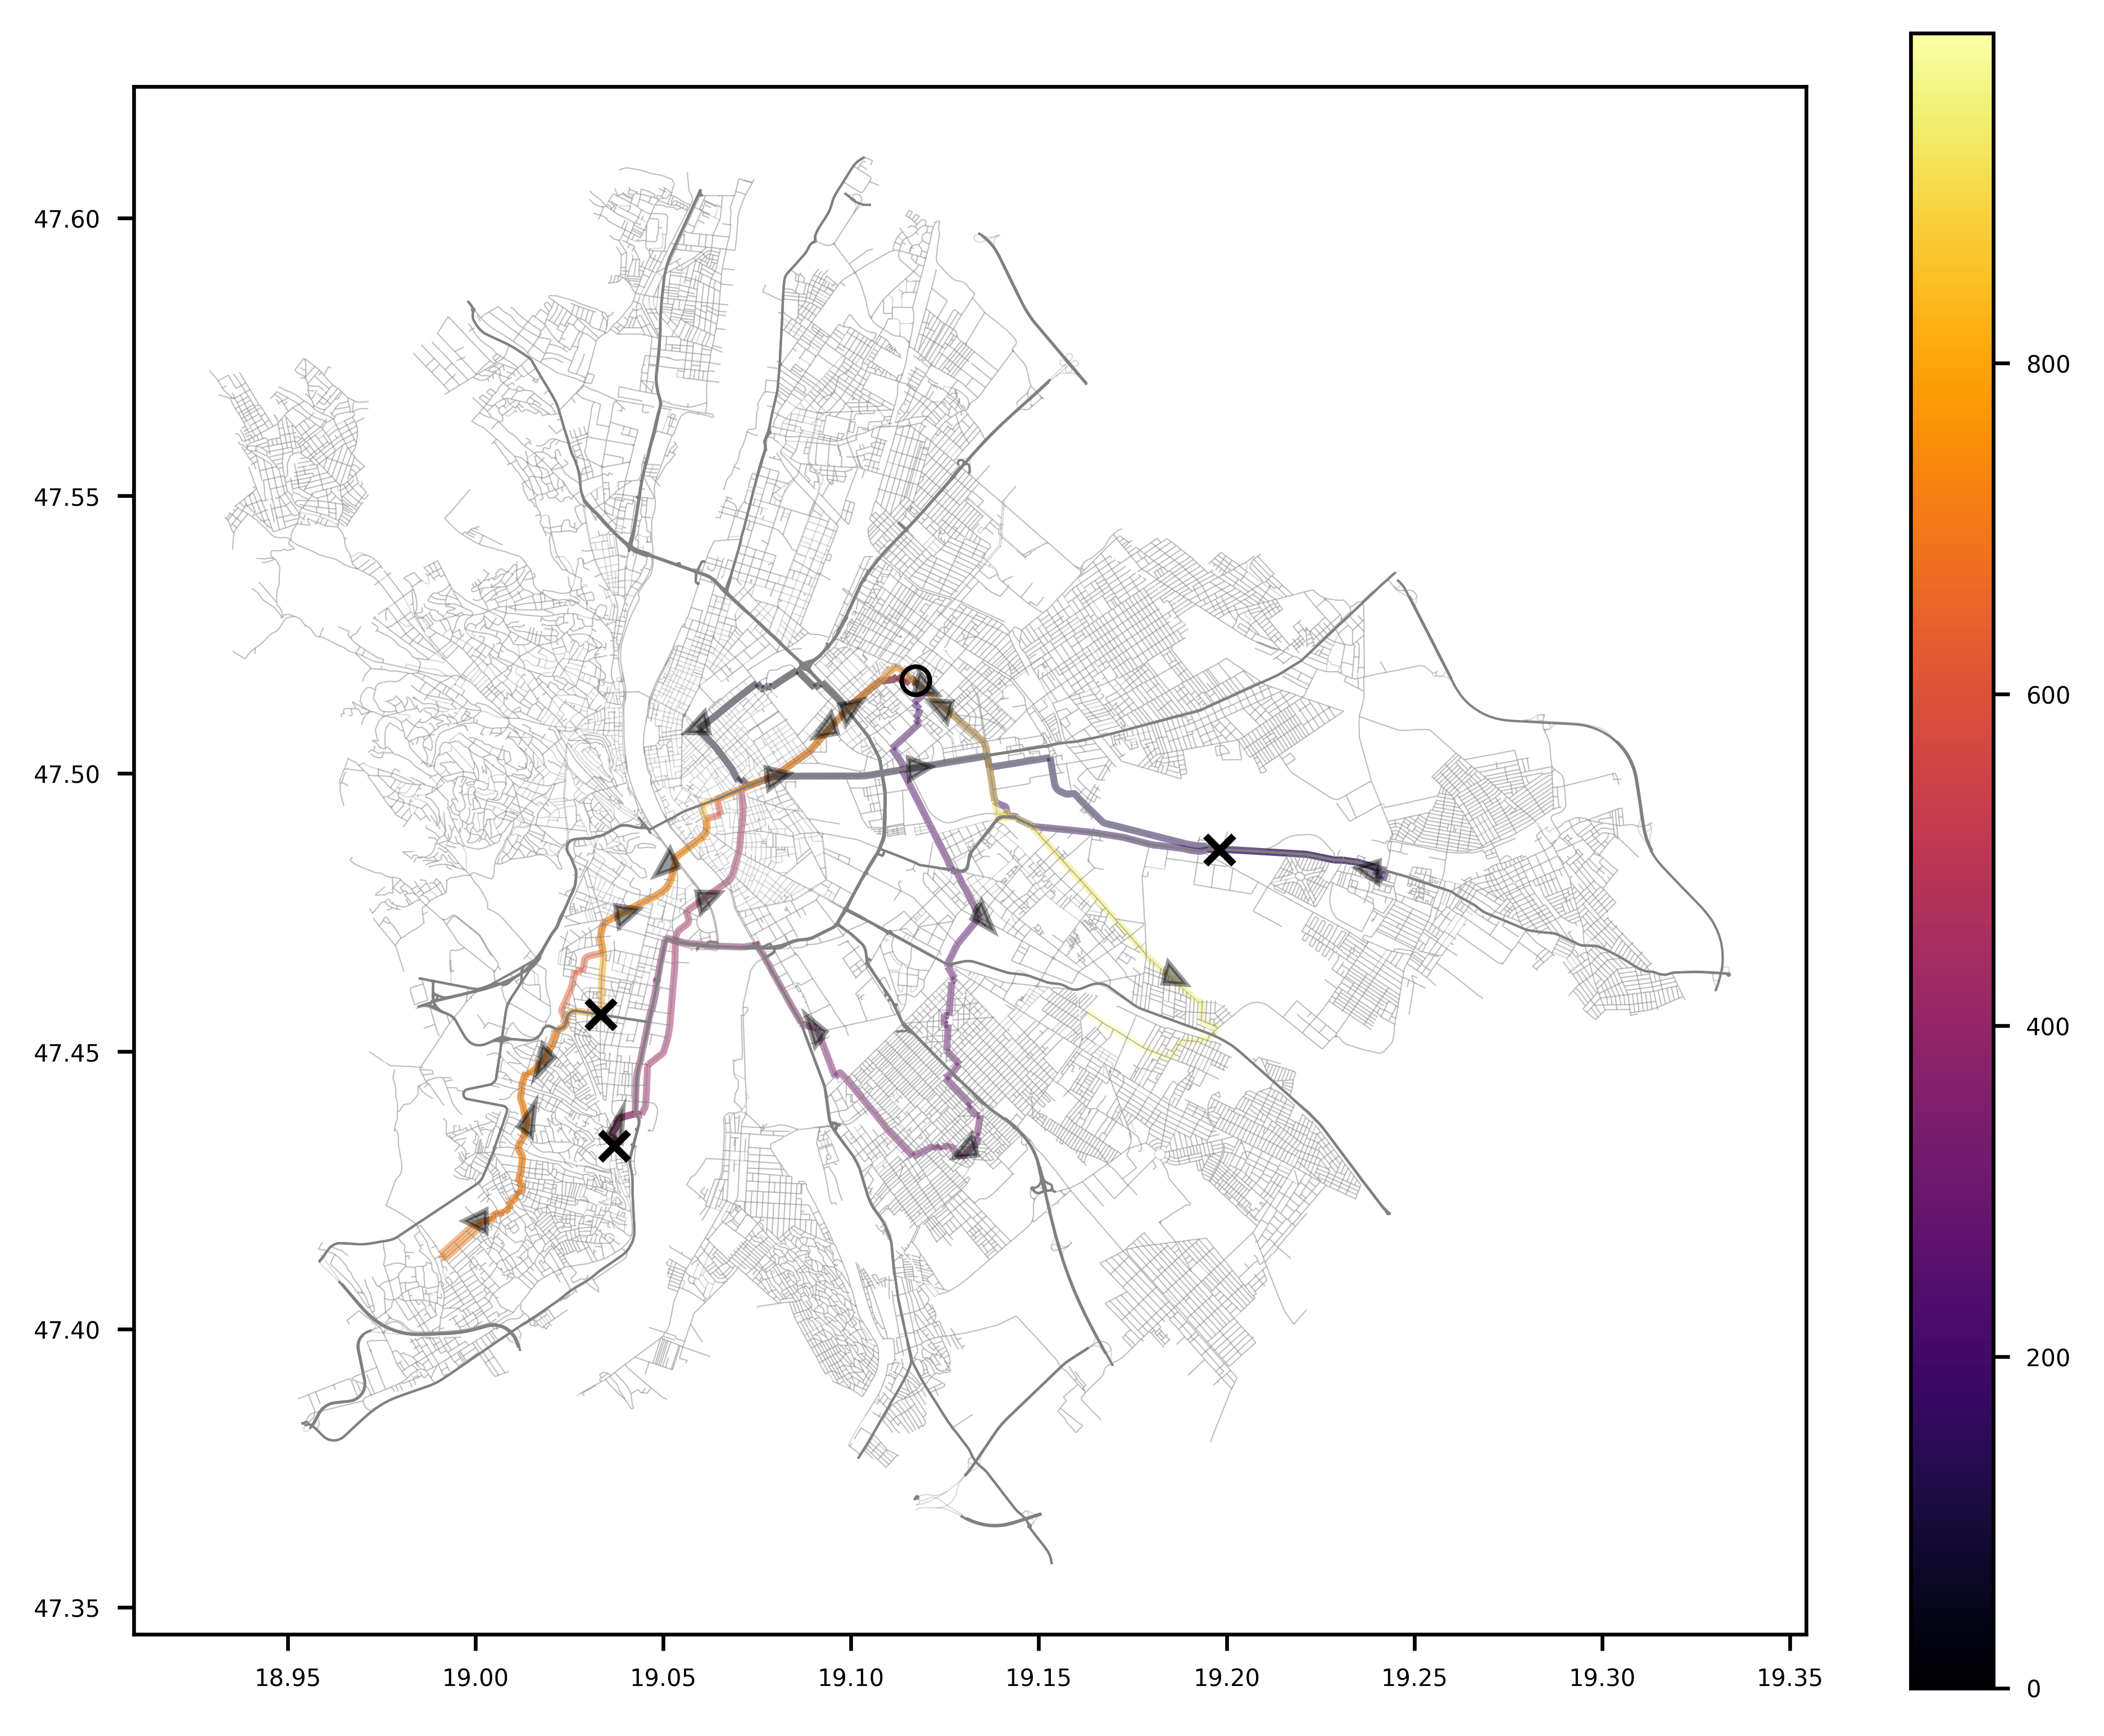

In [51]:
fig, axs = plt.subplots(1, 1, facecolor="w", figsize=(8, 6.5), dpi=600)

ax = axs

arterial_roads = edges.loc[edges.highway.isin(["motorway", "trunk", "primary", "primary_link"])]
other_roads = edges.loc[~edges.highway.isin(["motorway", "trunk", "primary", "primary_link"])]

arterial_roads.plot(ax=ax, lw=0.5, color="gray", zorder=3)
other_roads.plot(ax=ax, lw=0.25, color="gray", alpha=0.3, zorder=3)

edges_ri.merge(pos_list, on=("u", "v"), how="right", copy=True).plot("Step", ax=ax, cmap="inferno", legend=True, alpha=0.5)

ax.scatter(nodes.loc[model.schedule.agents[0].homebase, "x"], nodes.loc[model.schedule.agents[0].homebase, "y"], marker="o", facecolors="none", edgecolors="k", zorder=5)

for pt in model.homesick_points:
    ax.scatter(nodes.loc[pt, "x"], nodes.loc[pt, "y"], marker="x", color="k", zorder=4)

for sigpt in pos_list.iloc[::50].iterrows():
    if sigpt[1]["Step"] > 0:
        ux, uy = nodes.loc[sigpt[1]["u"], "x"], nodes.loc[sigpt[1]["u"], "y"]


for arrowpt in pos_list.iloc[::50].iterrows():
    if arrowpt[1]["Step"] > 0:
        plt.arrow(nodes.loc[arrowpt[1]["u"], "x"],
                  nodes.loc[arrowpt[1]["u"], "y"],
                  (nodes.loc[arrowpt[1]["v"], "x"] - nodes.loc[arrowpt[1]["u"], "x"])*1.6/10,
                  (nodes.loc[arrowpt[1]["v"], "y"] - nodes.loc[arrowpt[1]["u"], "y"])/10, lw=1, head_width=0.004, zorder=6, color="k", alpha=0.4)

plt.savefig("homesick_abm.pdf")